## **Business Case : TELUS NLP Project - Contract Risk Scoring Model**

<b> Collaborators on this Project </b>

1. Ashish Gupta
2. Mona Hasanzadeh </b>

<b>Objective:</b>

Looking at the textual contents and clauses of our contract with TELUS suppliers / vendors, we would like to identify risk in each contract and label each contract based on their risk level. Perhaps, this is an unsupervised algorithm and needs clustering model.

<b>Background</b>

The digital revolution in the world has created a vast ocean of data. This is available in all formats where data can be nicely structured into tables as well as unstructured found in text files, PDF files etc. There is a trove of information hidden in unstructured data that an organization can benefit from.

Here at TELUS we are looking to benefit from all the data that is contained in contracts. In particular, we are looking to extract the items below to help up assess and quantify risks for each contract :

1) <b>Service Level Agreements (SLA):</b> SLA is an agreement between two parties in a contract that specifies details of service subject of the contract. For example, customer based SLA is an agreement with one customer, covering all the services used by this customer. Let’s consider the relationship between you and your telecom operator. You use the voice services, SMS services, data services, and several other services of the telecom operator. For all these services, you have only one contract between you and the telecom operator. Similarly, if the IT service provider provides several services for the business and the customers, and if all the service levels are documented in one service level agreement for the provided services, it will be a customer based SLA).

We are interested to identify which contracts among thousands of contract at TELUS have SLA clause. We not only would like you to determine if a contract has SLA, but also extract the SLA terms and details.

2) <b>Warranty:</b> Does the contract contain any warranty clauses and if so extract it.

3) <b>Signing Bonus:</b> We want you to determine if there was any bonus offered to TELUS by signing the contract with the Vendor. Also, extract those text related to signing bonus. For instance, vendor X may offer $100,000 marketing fund once TELUS signs the contract as a bonus.

4) <b>No Charge add-ons:</b> Similar to signing bonus, there are some add-ons at no charge if TELUS sign up for the core services offered by vendor.

5) <b>Marketing Development Funds:</b> Market development funds or MDF are used in an indirect sales channel where funds are made available by a manufacturer or brand to help affiliates, channel partners, resellers, VARs, or distributors to sell its products and create local awareness about the national brand. Co-op Funds is a synonym for Market Development Funds.

6) <b>Committed Funds:</b> Value of the funds TELUS has committed to pay regardless how much service TELUS consumes.

7) <b>Committed volume:</b> Such as number of hours or quantity of goods that TELUS has agreed to consume.

8) <b>Currency (USD or CAD): </b> Some contracts can be in USD or CAD so we want to know the impact of currency fluctuations.

9) <b>Contract Category:</b> What is the category in which contract fall in. For instance, IT, fleet, field services, consulting, cleaning.

For each items you are tracking, we need to know what is your confidence score. For example, if you extract SLA, then how confident (90% or 80%) are you that there is an SLA in the contract. Same goes for all other items.

<b>Scope:</b>

These data points you are helping to extract from TELUS contracts are crucial for the success of our future steps when building machine learning solutions that can predict risk of each of our contract. These outcomes will be provided to TELUS executive leadership for better decision making.

### **Data Setup and Structure**

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import os
os.chdir("/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements")
os.listdir()

['PDF', 'JSON', 'Pickle', 'Processed Json', 'Processed Pickle']

### **Install and Import Libraries**

In [0]:
!pip install pdfminer
!pip install loader
!pip install inscriptis==0.0.3.2
!pip3 install readability-lxml
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [0]:
import bs4
import time
import pickle
import logging
import codecs
import gensim
import unicodedata
import loader
import warnings

from collections import Counter
from sklearn.model_selection import KFold
from inscriptis import get_text

from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader

from readability.readability import Unparseable
from readability.readability import Document as Paper
from nltk import pos_tag, sent_tokenize, wordpunct_tokenize

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.matutils import sparse2full
from gensim.corpora import Dictionary
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk.tokenize import WordPunctTokenizer
import unicodedata
from nltk.corpus import wordnet as wn
from gensim.matutils import sparse2full
from gensim.corpora import Dictionary

import os
import json
import re
import pickle

from nltk import pos_tag, word_tokenize
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader
from nltk import ne_chunk
from itertools import groupby
from nltk.corpus import wordnet as wn
from nltk.chunk import tree2conlltags
from nltk.probability import FreqDist
from nltk.chunk.regexp import RegexpParser
from unicodedata import category as unicat
from math import log
from collections import Counter, defaultdict

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import collections
import pandas as pd

import io
import glob
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage

from nltk.util import ngrams
from nltk.probability import ProbDistI, FreqDist, ConditionalFreqDist

log = logging.getLogger("readability.readability")
log.setLevel('WARNING')

DOC_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.json'
PKL_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.pickle'
CAT_PATTERN = r'([a-z_\s]+)/.*'

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import codecs
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from nltk import sent_tokenize, word_tokenize

from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx

import itertools
import tabulate
from nltk import ne_chunk

import heapq
from operator import itemgetter
import networkx as nx

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import AgglomerativeClustering
from nltk.cluster import KMeansClusterer
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from gensim.matutils import sparse2full
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.sklearn_api import lsimodel, ldamodel

### **Convert the PDF Files to JSON Format**

In [0]:
def extract_text_from_pdf(pdf_path):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle)
    page_interpreter = PDFPageInterpreter(resource_manager, converter)
    with open(pdf_path, 'rb') as fh:
        for page in PDFPage.get_pages(fh, 
                                      caching=True,
                                      check_extractable=True):
            page_interpreter.process_page(page)
        text = fake_file_handle.getvalue()
    # close open handles
    converter.close()
    fake_file_handle.close()
    if text:
      return text

1. We will now loop over each page of the PDF and extract the first 50,000 characters of each page.
2. We create a dictionary with the page number as the key and the 50,000 characters as the value and append it to the Page’s list. 
3. Finally, we write the file using the json module’s dump command.

In [0]:
def export_as_json(pdf_path, json_path):
    filename = os.path.splitext(os.path.basename(pdf_path))[0]
    data = {'Filename': filename}
    data['Text'] = extract_text_from_pdf(pdf_path)
    data['Text'] = data['Text'].replace('\n', " ")
    data['Text'] = data['Text'].replace('\t', " ")
    data['Text'] = data['Text'].replace('\f', " ")
    data['Text'] = data['Text'].replace('\u2018', " ") 
    data['Text'] = data['Text'].replace('\u2019', " ") 
    data['Text'] = data['Text'].replace('\u2020', " ") 
    data['Text'] = data['Text'].replace('\u2022', " ") 
    data['Text'] = data['Text'].replace('\u2021', " ") 
    data['Text'] = data['Text'].replace('\u201c', " ")
    data['Text'] = data['Text'].replace('\u201d', " ")
    data['Text'] = data['Text'].replace('\u00e9', " ")
    data['Text'] = data['Text'].replace('\u2013', " ")
    data['Text'] = data['Text'].replace('\uf0b7', " ")
    data['Text'] = data['Text'].replace('\u00a0', " ")
    data['Text'] = data['Text'].replace('\u00bb', " ")
    data['Text'] = data['Text'].replace('\u00a9', " ")
    data['Text'] = data['Text'].replace('\u2026', " ")
    data['Text'] = data['Text'].replace('\ua7f7', " ")
    data['Text'] = data['Text'].replace('https://', " ")
    data['Text'] = data['Text'].replace('http://', " ")
    data['Text'] = re.sub("[!@#~`%^&*(){};:/<>?\|_]", " ", data['Text'])
    with open(json_path, 'w') as fh:
        json.dump(data['Text'], fh, ensure_ascii=False)

Save JSON files in the Directory

In [0]:
for file_name in glob.glob("/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/PDF/*.pdf"):
  for json_file_name in glob.glob("/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/JSON/"):
    pdf_path = file_name
    getfirstSplit = file_name.split('.pdf')[0]
    getSecondSplit = getfirstSplit.split('/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/PDF/')[1]
    json_path = json_file_name + getSecondSplit+ '.json'
    export_as_json(pdf_path, json_path)

In [0]:
#check the files
os.chdir("/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/JSON/")
os.listdir()

['MRA-1.json',
 'MRA-2.json',
 'MSA-2.json',
 'MSA-4.json',
 'MSA-3.json',
 'msa-6.json',
 'msa-7.json',
 'mra-3.json',
 'mra-4.json',
 'MSA-1.json',
 'MSA-5.json',
 'msaas-1.json',
 'msaas-2.json',
 'msaas-5.json',
 'telecom-1.json',
 'msaas-4.json',
 'msaas-3.json',
 'telecom-4.json',
 'telecom-3.json',
 'telecom-6.json',
 'telecom-2.json']

### **Preprocess the JSON Files**

In [0]:
class Preprocessor(object):
    """
    The preprocessor wraps a corpus object PlaintextCorpusReader and manages the stateful tokenization and part of 
    speech tagging into a directory that is stored in a format that can be read by the PickledCorpusReader.
    """

    def __init__(self, corpus, target=None, **kwargs):
        """
        The corpus is the PlaintextCorpusReader to preprocess and pickle.
        The target is the directory on disk to output the pickled corpus to.
        """
        self.corpus = corpus
        self.target = target

    def fileids(self, fileids=None, categories=None):
        """
        Helper function access the fileids of the corpus
        """
        if fileids:
            return fileids
        return self.corpus.fileids()

    def abspath(self, fileid):
        """
        Returns the absolute path to the target fileid from the corpus fileid.
        """
        # Find the directory, relative from the corpus root.
        parent = os.path.relpath(
            os.path.dirname(self.corpus.abspath(fileid)), self.corpus.root
        )

        # Compute the name parts to reconstruct
        basename  = os.path.basename(fileid)
        name, ext = os.path.splitext(basename)

        # Create the pickle file extension
        basename  = name + '.pickle'

        # Return the path to the file relative to the target.
        return os.path.normpath(os.path.join(self.target, parent, basename))

    def tagging(self, fileid):
        """
        Tags a document in the corpus. Tokenization done by PlaintextCorpusReader
        Returns a generator of paragraphs, which are lists of sentences,
        which in turn are lists of part of speech tagged words.
        """
        for paragraph in self.corpus.paras(fileids=fileid):
            yield [pos_tag(sent) for sent in paragraph]
            
    def process(self, fileid):
        """
        Writes the document as a pickle to the target location.
        This method is called multiple times from the transform runner.
        """
        
        # Compute the outpath to write the file to.
        target = self.abspath(fileid)
        parent = os.path.dirname(target)
        
        # Make sure the directory exists
        if not os.path.exists(parent):
            os.makedirs(parent)
        
        # Make sure that the parent is a directory and not a file
        if not os.path.isdir(parent):
            raise ValueError("Please supply a directory to write preprocessed data to.")
        
        # Create a data structure for the pickle
        document = list(self.tagging(fileid))
        
        # Open and serialize the pickle to disk
        with open(target, 'wb') as f:
            pickle.dump(document, f, pickle.HIGHEST_PROTOCOL)
        
        # Clean up the document
        del document
        
        # Return the target fileid
        return target

    def transform(self, fileids=None, categories=None):
        """
        Transform the wrapped corpus, writing out the segmented, tokenized,
        and part of speech tagged corpus as a pickle to the target directory.
        """

        # Make the target directory if it doesn't already exist
        if not os.path.exists(self.target):
            os.makedirs(self.target)
        
        # Resolve the fileids to start processing and return the list of 
        # target file ids to pass to downstream transformers. 
        return [
            self.process(fileid)
            for fileid in self.fileids(fileids, categories)
        ]

### **Preprocess JSON Files and Create Pickle Objects**



In [0]:
# preprocessing text corpus to pickle corpus
text_corpus = PlaintextCorpusReader('/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/JSON/', '.*\.json')

preprocessor = Preprocessor(text_corpus, target='/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Pickle')
preprocessor.transform()

['/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Pickle/MRA-1.pickle',
 '/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Pickle/MRA-2.pickle',
 '/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Pickle/MSA-1.pickle',
 '/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Pickle/MSA-2.pickle',
 '/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Pickle/MSA-3.pickle',
 '/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Pickle/MSA-4.pickle',
 '/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Pickle/MSA-5.pickle',
 '/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Pickle/mra-3.pickle',
 '/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Pickle/mra-4.pickle',
 '/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Pickle/msa-6.pickle',
 '/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Pickle/msa-7.pickle',
 '/gdrive/My Drive/As

### **Read the Pickle Files**

In [0]:
PKL_PATTERN = r'.*\.pickle'
CAT_PATTERN = None

class PickledCorpusReader(CategorizedCorpusReader, CorpusReader):

    def __init__(self, root, fileids=PKL_PATTERN, **kwargs):
        """
        Initialize the corpus reader. Call superclass CategorizedCorpusReader 
        and CorpusReader initializers.
        """
        # Add the default category pattern if not passed into the class.
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN

        CategorizedCorpusReader.__init__(self, kwargs)
        CorpusReader.__init__(self, root, fileids)

    def resolve(self, fileids, categories):
        """
        Returns a list of fileids or categories depending on what is passed
        to each internal corpus reader function. 
        """
        if fileids is not None and categories is not None:
            raise ValueError("Specify fileids or categories, not both")

        if categories is not None:
            return self.fileids(categories)
        return fileids

    def docs(self, fileids=None, categories=None):
        """
        Returns the document loaded from a pickled object for every file in
        the corpus. Similar to the BaleenCorpusReader, this uses a generator
        to acheive memory safe iteration.
        """
        # Resolve the fileids and the categories
        fileids = self.resolve(fileids, categories)

        # Create a generator, loading one document into memory at a time.
        for path, enc, fileid in self.abspaths(fileids, True, True):
            with open(path, 'rb') as f:
                yield pickle.load(f)

    def paras(self, fileids=None, categories=None):
        """
        Returns a generator of paragraphs where each paragraph is a list of
        sentences, which is in turn a list of (token, tag) tuples.
        """
        for doc in self.docs(fileids, categories):
            for paragraph in doc:
                yield paragraph

    def sents(self, fileids=None, categories=None):
        """
        Returns a generator of sentences where each sentence is a list of
        (token, tag) tuples.
        """
        for paragraph in self.paras(fileids, categories):
            for sentence in paragraph:
                yield sentence

    def tagged(self, fileids=None, categories=None):
        for sent in self.sents(fileids, categories):
            for token in sent:
                yield token

    def words(self, fileids=None, categories=None):
        """
        Returns a generator of (token, tag) tuples.
        """
        for token in self.tagged(fileids, categories):
            yield token[0]

    def describe(self, fileids=None, categories=None):
        """
        Performs a single pass of the corpus and
        returns a dictionary with a variety of metrics
        concerning the state of the corpus.
        """

        # Structures to perform counting.
        counts  = nltk.FreqDist()
        tokens  = nltk.FreqDist()

        # Perform single pass over paragraphs, tokenize and count
        for para in self.paras(fileids, categories):
            counts['paras'] += 1

            for sent in para:
                counts['sents'] += 1

                for word in sent:
                    counts['words'] += 1
                    tokens[word[0]] += 1

        # Compute the number of files and categories in the corpus
        n_fileids = len(self.resolve(fileids, categories) or self.fileids())
        n_topics  = len(self.categories(self.resolve(fileids, categories)))

        # Return data structure with information
        return {
            'files':  n_fileids,
            'topics': n_topics,
            'paras':  counts['paras'],
            'sents':  counts['sents'],
            'words':  counts['words'],
            'vocab':  len(tokens),
            'lexdiv': float(counts['words']) / float(len(tokens)),
            'ppdoc':  float(counts['paras']) / float(n_fileids),
            'sppar':  float(counts['sents']) / float(counts['paras']),
        }

In [0]:
corpus = PickledCorpusReader(root='/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Pickle')
docs = corpus.docs()
words  = Counter(corpus.words())
print("Unique Words : {:,} , Frequency of words : {:,} ".format(len(words.keys()), sum(words.values())))

sentences  = corpus.sents()
print("Total Sentences : {:,}".format(len(list(sentences))))

Unique Words : 7,488 , Frequency of words : 159,745 
Total Sentences : 5,183


### **Corpus Data Visualizations**

#### **Sample Word Cloud for Corpus**

In [0]:
#lets check some of the unique words generated

stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12.5,12.5))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=10)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [0]:
words_dataframe = pd.DataFrame.from_dict(words, orient='index').reset_index()

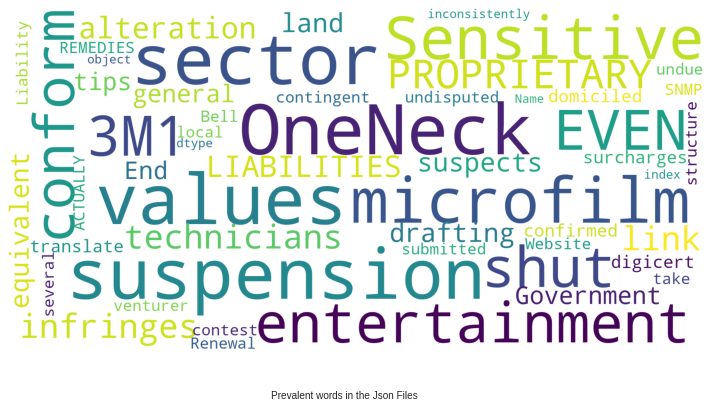

In [0]:
show_wordcloud(words_dataframe["index"].sample(50), title = 'Prevalent words in the Json Files')

#### **Frequency Distribution for Unigrams for a document**

[Text(0, 0, 'digicert'),
 Text(0, 0, 'master'),
 Text(0, 0, 'reseller'),
 Text(0, 0, 'agreement'),
 Text(0, 0, 'entity'),
 Text(0, 0, 'business'),
 Text(0, 0, 'services'),
 Text(0, 0, 'addendum'),
 Text(0, 0, 'references'),
 Text(0, 0, 'authorized')]

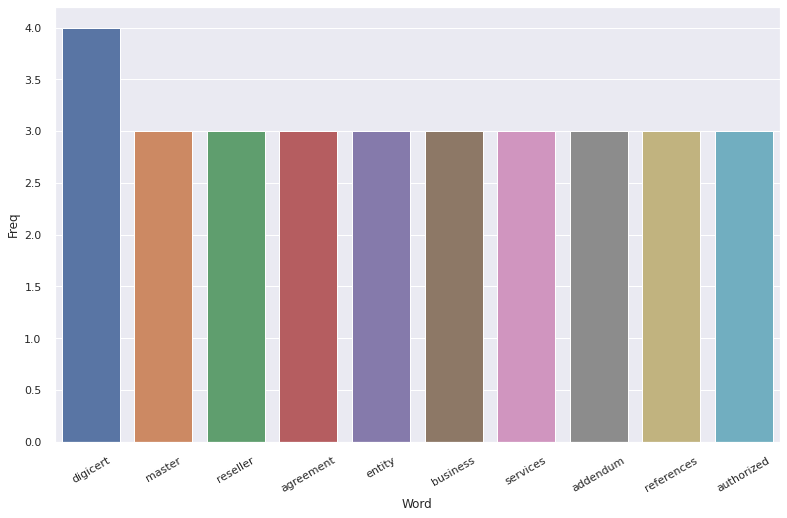

In [0]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer(analyzer='word', stop_words = 'english', ngram_range=(1, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

#Convert most freq words to dataframe for plotting bar plot
words  = Counter(corpus.words())
top_words = get_top_n_words(words, n=10)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

### **Data Preprocessing and Transformation**

#### **Step 1: Applying Word Net Lemmatizer to analyze the tokens**

In [0]:
class TextNormalizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, language='english'):
        self.stopwords = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords
      
    def normalize(self, document):
        return [
          self.lemmatize(token, tag).lower()
          for paragraph in document
          for sentence in paragraph
          for (token, tag) in sentence
          if not self.is_punct(token) and not self.is_stopword(token)
        ]
      
    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)
        
        return self.lemmatizer.lemmatize(token, tag)
    
    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        for document in documents:
            yield self.normalize(document)

In [0]:
## Main Program Execution Starts here  ########       
# Use the path where you saved your input dataset in below statement
normal = TextNormalizer()
normal.fit(docs)
normalized_docs = list(normal.transform(docs))
for x in range(21): 
    print (normalized_docs[x])

['8', '28', '2019', 'master', 'reseller', 'agreement', 'master', 'reseller', 'agreement', 'agreement', 'digicert', 'inc', 'digicert', 'entity', 'business', 'reselling', 'services', 'reseller', 'execute', 'addendum', 'reference', 'agreement', 'electronically', 'accept', 'agreement', 'via', 'digicert', 'online', 'service', 'resell', 'services', 'reseller', 'hereby', 'accept', 'agreement', 'individual', 'individual', 'enter', 'agreement', 'behalf', 'reseller', 'represent', 'warrant', 'authorized', 'representative', 'reseller', 'authority', 'bind', 'reseller', 'agreement', '1', 'definitions', 'addendum', 'mean', 'mutually', 'agree', 'upon', 'addendum', 'purchase', 'schedule', 'order', 'form', 'purchasing', 'document', 'set', 'forth', 'commercial', 'term', 'resale', 'services', 'whether', 'document', 'hard', 'copy', 'online', 'certificates', 'mean', 'type', 'digital', 'certificate', 'digicert', 'materials', 'mean', 'hard', 'electronic', 'copy', 'digicert', 'technical', 'manual', 'sale', 'ma

#### **Step 2 : Extracting the key phrases from each document to extract specific terms as mentioned in the business case**

In [0]:
GRAMMAR = r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'
GOODTAGS = frozenset(['JJ','JJR','JJS','NN','NNP','NNS','NNPS'])
GOODLABELS = frozenset(['PERSON', 'ORGANIZATION', 'FACILITY', 'GPE', 'GSP'])

class KeyphraseExtractor(BaseEstimator, TransformerMixin):
    """
    Wraps a PickledCorpusReader consisting of pos-tagged documents.
    """
    def __init__(self, grammar=GRAMMAR,language='english'):
        self.grammar = GRAMMAR
        self.chunker = RegexpParser(self.grammar)
        self.stopwords = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()

    def is_stopword(self, token):
        return token.lower() in self.stopwords
    
    def normalize(self, sent):
        """
        Removes punctuation from a tokenized/tagged sentence and
        lowercases words.
        """
        is_punct = lambda word: all(unicat(char).startswith('P') for char in word)
        sent = filter(lambda t: not is_punct(t[0]), sent)
        # The Stop word technique didn't produce great results for Key Phrase Extractor function
        # sent = filter(lambda t: not self.is_stopword(t[0]), sent)
        sent = map(lambda t: (t[0].lower(), t[1]), sent)
        return list(sent)

    def extract_keyphrases(self, document):
        """
        For a document, parse sentences using our chunker created by
        our grammar, converting the parse tree into a tagged sequence.
        Yields extracted phrases.
        """
        for sents in document:
            for sent in sents:
                sent = self.normalize(sent)
                if not sent: continue
                chunks = tree2conlltags(self.chunker.parse(sent))
                phrases = [
                    " ".join(word for word, pos, chunk in group).lower()
                    for key, group in groupby(
                        chunks, lambda term: term[-1] != 'O'
                    ) if key
                ]
                for phrase in phrases:
                    yield phrase

    def fit(self, documents, y=None):
        return self

    def transform(self, documents):
        for document in documents:
            yield list(self.extract_keyphrases(document))

In [0]:
docs = corpus.docs()
phrase_extractor = KeyphraseExtractor()
key_phrases = list(phrase_extractor.fit_transform(docs))

for x in range(21): 
    print (key_phrases[x])

['master reseller agreement', 'master reseller agreement', 'agreement', 'digicert inc digicert', 'entity', 'business reselling services reseller', 'addendum', 'agreement', 'agreement via digicert', 'online services', 'services reseller hereby', 'agreement', 'individuals', 'agreement on behalf', 'reseller', 'authorized representatives of reseller', 'authority', 'reseller', 'agreement', 'definitions addendum', 'addendum purchase schedule order form', 'other purchasing document', 'forth commercial terms', 'resale of services', 'such document', 'hard copy', 'online', 'certificates', 'type of digital certificate', 'digicert materials', 'electronic copies', 'digicert technical manual sales', 'material hardware', 'software', 'services that digicert', 'reseller', 'digicert pki', 'digicert public key infrastructure', 'services for individuals', 'organizations', 'effective date', 'date reseller', 'agreement', 'intellectual property rights', 'rights', 'intangible property', 'unregistered united s

#### **Searching for "Service Level Agreement" key phrases in Corpus**

In [0]:
for x in range(21): 
  if 'service level agreement' in key_phrases[x]:
    print ('service level agreement keyword found in {}th document at the index {}'.format(x+1, key_phrases[x].index('service level agreement')))

service level agreement keyword found in 6th document at the index 678
service level agreement keyword found in 13th document at the index 241
service level agreement keyword found in 14th document at the index 2047


**As you can see, "service level agreement" appears on 6th, 13th and 14th document.**

#### **Summarize Function for specific keywords in the Corpus documents**


In [0]:
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx

def read_article(file_name):
    file = open(file_name, "r")
    filedata = file.readlines()
    article = filedata[0].split(". ")
    sentences = []

    for sentence in article:
        #print(sentence)
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))       
    sentences.pop()
    
    return sentences

def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)
 
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix

def generate_summary(file_name, top_n=5):
    stop_words = stopwords.words('english')
    summarize_text = []

    # Step 1 - Read text anc split it
    sentences =  read_article(file_name)

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)

    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph)

    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
    print("Indexes of top ranked_sentence order are ", ranked_sentence)    

    for i in range(top_n):
      summarize_text.append(" ".join(ranked_sentence[i][1]))

    # Step 5 - Offcourse, output the summarize text
    print("Summarize Text: \n", ". ".join(summarize_text))

#### **Generate Summary for SLA from MSA-4.json (6th Document)**

In [0]:
document = read_article('/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/JSON/MSA-4.json')
print("Total Paragraphs : {}".format(len(document)-1))
token = ['SERVICE','LEVEL']
for x in range(len(document)):
  if all(y in document[x] for y in token):
    print ("SERVICE LEVEL AGREEMENT found in Starting paragraph : {}".format(x))
    x_start = x

Total Paragraphs : 477
SERVICE LEVEL AGREEMENT found in Starting paragraph : 441


To extract the ending paragraph index, We had to check our PDF Document and verified the last line of the SLA i.e. 

**"CREDITS
ARE THE SOLE AND EXCLUSIVE REMEDY UNDER THIS ADDENDUM AND THE MSA FOR
ANY PERFORMANCE FAILURE RELATED TO OR ARISING FROM THE SERVICE OFFERED
HEREUNDER." - MSA-4.PDF** 

In [0]:
token = ['Credit','Schedule']
for x in range(len(document)):
  if all(y in document[x] for y in token):
    print ("Ending paragraph for SERVICE LEVEL AGREEMENT found in : {}".format(x)) # for ending paragraph of SLA
    x_finish = x

Ending paragraph for SERVICE LEVEL AGREEMENT found in : 476


In [0]:
#Merge the text list to single list.
Updated_Document = []
for i in range(x_start,x_finish):
  Updated_Document = Updated_Document + document[i] + ['.']

# using list comprehension 
listToStr = ' '.join([str(elem) for elem in Updated_Document]) 

listToStr = " ".join(listToStr.split())
listToStr = listToStr.replace(" . ", ". ")

print(listToStr)  

By Name Title Authorized Signatory Date CUSTOMER By Name Title Date 5 EXHIBIT 1 SERVICE LEVEL AGREEMENT Service Availability Pilot guarantees that your service s connection to the Internet will be available at least 99 of the time. Disruptions to your service that result in the inability to access the Internet in its entirety and where such disruption is in excess of 1 of the time in a given calendar month will result in the automatic application of account credits in accordance with the credit schedule. There are many factors outside of Pilot s control that may result in service disruption including, but not limited to, scenarios documented elsewhere in this agreement. The determination of service availability is made at Pilot s sole discretion. Packet Loss Pilot guarantees that packet loss between any two points on Pilot's network will not exceed 0.1 at any time. In the event that packet loss is reported and observed in excess of this target, credit will automatically be applied in a

In [0]:
with open(r'/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Processed Json/SLA_Text1.json', 'w') as fh:
        json.dump(listToStr, fh, ensure_ascii=False)

In [0]:
generate_summary(r'/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Processed Json/SLA_Text1.json', 5)

Indexes of top ranked_sentence order are  [(0.047522029619513406, ['In', 'the', 'event', 'of', 'a', 'service', 'degradation', 'or', 'service', 'outage', 'that', 'both', 'impacts', 'your', 'Pilot', 'internet', 'connection', 'and', 'is', 'eligible', 'for', 'an', 'account', 'credit,', 'Pilot', 'will', 'consider', 'those', 'dependent', 'services', 'as', 'affected', 'services', 'for', 'the', 'purposes', 'of', 'credit', 'calculation']), (0.04672293977094974, ['Credit', 'Issuance', 'and', 'Refund', 'Policy', 'Pilot', 'will', 'issue', 'any', 'applicable', 'account', 'credits', 'within', '15', 'days', 'of', 'the', 'SLA', 'event']), (0.04331252549402022, ['Pilot', 'may', 'conduct', 'such', 'maintenance', 'at', 'any', 'time', 'provided', 'that', 'Pilot', 'has', 'provided', 'Customer', 'with', 'written', 'notice', 'of', 'such', 'maintenance', 'when', 'possible']), (0.03884420903440674, ['Credits', 'are', 'issued', 'at', 'the', 'sole', 'discretion', 'of', 'Pilot']), (0.03668206856042487, ['The', 'd

**The Summarized Text for Service level Agreement in 6th document is:**

*In the event of a service degradation or service outage that both impacts your Pilot internet connection and is eligible for an account credit, Pilot will consider those dependent services as affected services for the purposes of credit calculation. Credit Issuance and Refund Policy Pilot will issue any applicable account credits within 15 days of the SLA event. Pilot may conduct such maintenance at any time provided that Pilot has provided Customer with written notice of such maintenance when possible. Credits are issued at the sole discretion of Pilot. The determination of service availability is made at Pilot s sole discretion.*

#### **Generate Summary for SLA from msaas-2.json (13th Document)**

In [0]:
document = read_article('/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/JSON/msaas-2.json')
print("Total Paragraphs : {}".format(len(document)-1))
token = ['SERVICE','LEVEL']
for x in range(len(document)):
  if all(y in document[x] for y in token):
    print ("SERVICE LEVEL AGREEMENT found in Starting paragraph : {}".format(x))
    x_start = x

Total Paragraphs : 208
SERVICE LEVEL AGREEMENT found in Starting paragraph : 167


To extract the ending paragraph index, We had to check our PDF Document and verified the last line of the SLA i.e.

**"Intelex having the information necessary to replicate the reported problem with the SaaS."** - msaas-2.PDF

In [0]:
token = ['Intelex','replicate']
for x in range(len(document)):
  if all(y in document[x] for y in token):
    print ("Ending paragraph for SERVICE LEVEL AGREEMENT found in : {}".format(x)) # for ending paragraph of SLA
    x_finish = x

Ending paragraph for SERVICE LEVEL AGREEMENT found in : 203


In [0]:
#Merge the text list to single list.
Updated_Document = []
for i in range(x_start,x_finish):
  Updated_Document = Updated_Document + document[i] + ['.']

# using list comprehension 
listToStr = ' '.join([str(elem) for elem in Updated_Document]) 

listToStr = " ".join(listToStr.split())
listToStr = listToStr.replace(" . ", ". ")

print(listToStr)  

Intelex Technologies, ULC Master SaaS Subscription and Services Agreement Confidential Page 7 of 9 Revision Date 13.08.2019 v.1.7 SCHEDULE 1 SERVICE LEVEL AGREEMENT TERMS 1. ADDITIONAL DEFINITIONS 1.1 Business Day means any week day of the year Monday through Friday except for the following New Year s Day January 1 , and Christmas Day December 25. 1.2 Defect means any error, problem or malfunction of the SaaS such that the SaaS does not conform to the Documentation. 1.3 \"Downtime\" means any period where the SaaS is not available to the Authorized Users, excluding Exempt Downtime. 1.4 Exempt Downtime means Downtime that is i scheduled maintenance time necessary to implement any updates, upgrades or other modifications to the SaaS or perform routine, emergency or ad hoc maintenance activity and for which Intelex has provided Customer with reasonable advance notice or ii is caused by failure of equipment or services not provided by Intelex, including but not limited to, Customer infrast

In [0]:
with open(r'/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Processed Json/SLA_Text2.json', 'w') as fh:
        json.dump(listToStr, fh, ensure_ascii=False)

In [0]:
generate_summary(r'/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Processed Json/SLA_Text2.json', 2)

Indexes of top ranked_sentence order are  [(0.059755847063544205, ['Items', 'not', 'covered', 'by', 'Support', 'and', 'Maintenance', 'Services', 'Intelex', 'is', 'not', 'obligated', 'to', 'provide', 'Support', 'and', 'Maintenance', 'Services', 'for', 'errors', 'or', 'problems', 'caused', 'by', 'the', 'following', 'i', 'third-party', 'components', 'not', 'provided', 'by', 'Intelex,', 'including', 'Customer', 's', 'infrastructure', 'and', 'network', 'ii', 'use', 'of', 'the', 'SaaS', 'other', 'than', 'in', 'a', 'recommended', 'environment', 'described', 'in', 'the', 'Platform', 'Support', 'Policy', 'available', 'as', 'may', 'be', 'amended', 'from', 'time', 'to', 'time', 'ii', 'training', 'or', 'walk-throughs', 'of', 'the', 'SaaS,', 'change', 'requests,', 'end', 'user', 'requests', 'or', 'troubleshooting', 'with', 'end', 'users', 'or', 'iii', 'continued', 'use', 'of', 'a', 'version', 'of', 'the', 'SaaS', 'for', 'which', 'Support', 'and', 'Maintenance', 'Services', 'is', 'not', 'provided', 

**The Summarized Text for Service level Agreement in 13th document is:**

*Items not covered by Support and Maintenance Services Intelex is not obligated to provide Support and Maintenance Services for errors or problems caused by the following i third-party components not provided by Intelex, including Customer s infrastructure and network ii use of the SaaS other than in a recommended environment described in the Platform Support Policy available as may be amended from time to time ii training or walk-throughs of the SaaS, change requests, end user requests or troubleshooting with end users or iii continued use of a version of the SaaS for which Support and Maintenance Services is not provided in accordance with Section 3.3 above. Support and Maintenance Services means i online support to Customer s system administrator users relating to technical issues, errors or problems with the SaaS ii access to online resources via the online Intelex customer portal iii notification of and access to Intelex release patches and Documentation released by Intelex and iv notification of and access to Updates and Upgrades of the SaaS*

#### **Searching for "Warranty" Key Phrases in Corpus**

In [0]:
for x in range(21): 
  if 'warranty' in key_phrases[x]:
    print ('warranty keyword found in {}th document at the index {}'.format(x+1, key_phrases[x].index('warranty')))

warranty keyword found in 5th document at the index 1677
warranty keyword found in 7th document at the index 557
warranty keyword found in 8th document at the index 1176
warranty keyword found in 9th document at the index 1171
warranty keyword found in 12th document at the index 619
warranty keyword found in 13th document at the index 675
warranty keyword found in 15th document at the index 711
warranty keyword found in 16th document at the index 168


#### **Generate Summary for Warranty from MSA-3.json (5th Document)**

In [0]:
document = read_article('/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/JSON/MSA-3.json')
print("Total Paragraphs : {}".format(len(document)-1))
token = ['REPRESENTATIONS','WARRANTIES']
for x in range(len(document)):
  if all(y in document[x] for y in token):
    print ("WARRANTY found in Starting paragraph : {}".format(x))
    x_start = x;

Total Paragraphs : 654
WARRANTY found in Starting paragraph : 411
WARRANTY found in Starting paragraph : 420


To extract the ending paragraph index, We had to check our PDF Document and verified the last line of the Warranty i.e.

**THE RETURN OF ANY UNUSED DEPOSIT** - msaas-2.PDF

In [0]:
token = ['RETURN','UNUSED','DEPOSIT']
for x in range(len(document)):
  if all(y in document[x] for y in token):
    print ("Ending paragraph for Warranty found in : {}".format(x)) # for ending paragraph of warranty
    x_finish = x

Ending paragraph for Warranty found in : 425


In [0]:
#Merge the text list to single list.
Updated_Document = []
for i in range(413,x_finish):
  Updated_Document = Updated_Document + document[i] + ['.']

# using list comprehension 
listToStr = ' '.join([str(elem) for elem in Updated_Document]) 

listToStr = " ".join(listToStr.split())
listToStr = listToStr.replace(" . ", ". ")

print(listToStr)  

21.2. Customer acknowledges and agrees that Tucows does not guarantee that the API or any of the Tucows Services will meet the requirements of Customer or its Users. The API and the Tucows Services are provided as is without any warranty of any kind. 21.3. Independent third parties may supply some or all of components of the API or the Tucows Services. While Tucows makes every effort to ensure the accuracy of all information presented to its customers, Tucows makes no warranty as to the accuracy of any such information. 21.4. WITH REGARD TO THE API AND THE TUCOWS SERVICES, TUCOWS AND EACH OF ITS SUPPLIERS A EXPRESSLY DISCLAIMS ALL WARRANTIES AND OR CONDITIONS, EXPRESS OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, TITLE, NON-INFRINGEMENT, THE IMPLIED WARRANTIES AND CONDITIONS OF MERCHANTABILITY OR SATISFACTORY QUALITY AND FITNESS FOR A PARTICULAR PURPOSE AND NON-INFRINGEMENT OF THIRD PARTY RIGHTS B DOES NOT WARRANT THAT THE FUNCTIONS CONTAINED IN THE API OR THE TUCOWS SERVICES WILL MEET TH

In [0]:
with open(r'/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Processed Json/Warranty_Text1.json', 'w') as fh:
        json.dump(listToStr, fh, ensure_ascii=False)

In [0]:
generate_summary(r'/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Processed Json/Warranty_Text1.json', 3)

Indexes of top ranked_sentence order are  [(0.1808144432170251, ['WITH', 'REGARD', 'TO', 'THE', 'API', 'AND', 'THE', 'TUCOWS', 'SERVICES,', 'TUCOWS', 'AND', 'EACH', 'OF', 'ITS', 'SUPPLIERS', 'A', 'EXPRESSLY', 'DISCLAIMS', 'ALL', 'WARRANTIES', 'AND', 'OR', 'CONDITIONS,', 'EXPRESS', 'OR', 'IMPLIED,', 'INCLUDING,', 'BUT', 'NOT', 'LIMITED', 'TO,', 'TITLE,', 'NON-INFRINGEMENT,', 'THE', 'IMPLIED', 'WARRANTIES', 'AND', 'CONDITIONS', 'OF', 'MERCHANTABILITY', 'OR', 'SATISFACTORY', 'QUALITY', 'AND', 'FITNESS', 'FOR', 'A', 'PARTICULAR', 'PURPOSE', 'AND', 'NON-INFRINGEMENT', 'OF', 'THIRD', 'PARTY', 'RIGHTS', 'B', 'DOES', 'NOT', 'WARRANT', 'THAT', 'THE', 'FUNCTIONS', 'CONTAINED', 'IN', 'THE', 'API', 'OR', 'THE', 'TUCOWS', 'SERVICES', 'WILL', 'MEET', 'THE', 'CUSTOMER', 'S', 'REQUIREMENTS,', 'OR', 'THAT', 'THE', 'OPERATION', 'OF', 'THE', 'API', 'OR', 'THE', 'TUCOWS', 'SERVICES', 'WILL', 'BE', 'UNINTERRUPTED', 'OR', 'ERROR-FREE,', 'OR', 'THAT', 'DEFECTS', 'IN', 'THE', 'API', 'OR', 'TUCOWS', 'SERVICES'

**The Summarized Text for Warranty in 5th document is:**

*WITH REGARD TO THE API AND THE TUCOWS SERVICES, TUCOWS AND EACH OF ITS SUPPLIERS A EXPRESSLY DISCLAIMS ALL WARRANTIES AND OR CONDITIONS, EXPRESS OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, TITLE, NON-INFRINGEMENT, THE IMPLIED WARRANTIES AND CONDITIONS OF MERCHANTABILITY OR SATISFACTORY QUALITY AND FITNESS FOR A PARTICULAR PURPOSE AND NON-INFRINGEMENT OF THIRD PARTY RIGHTS B DOES NOT WARRANT THAT THE FUNCTIONS CONTAINED IN THE API OR THE TUCOWS SERVICES WILL MEET THE CUSTOMER S REQUIREMENTS, OR THAT THE OPERATION OF THE API OR THE TUCOWS SERVICES WILL BE UNINTERRUPTED OR ERROR-FREE, OR THAT DEFECTS IN THE API OR TUCOWS SERVICES WILL BE CORRECTED AND C NEITHER WARRANTS NOR MAKES ANY REPRESENTATIONS REGARDING THE USE OR THE RESULTS OF API OR THE TUCOWS SERVICES, OR RELATED DOCUMENTATION IN TERMS OF THEIR CORRECTNESS, ACCURACY, QUALITY, RELIABILITY, OR OTHERWISE. Customer acknowledges and agrees that Tucows does not guarantee that the API or any of the Tucows Services will meet the requirements of Customer or its Users. The API and the Tucows Services are provided as is without any warranty of any kind*

#### **Generate Summary for Warranty from MSA-5.json (7th Document)**

In [0]:
document = read_article('/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/JSON/MSA-5.json')
print("Total Paragraphs : {}".format(len(document)-1))
token = ['WARRANTY']
for x in range(len(document)):
  if all(y in document[x] for y in token):
    print ("WARRANTY found in Starting paragraph : {}".format(x))
    x_start = x;

Total Paragraphs : 489
WARRANTY found in Starting paragraph : 111
WARRANTY found in Starting paragraph : 115
WARRANTY found in Starting paragraph : 116
WARRANTY found in Starting paragraph : 117


To extract the ending paragraph index, We had to check our PDF Document and verified the last line of the Warranty i.e.

**THE WARRANTY PROVIDED IS SUBJECT TO THE LIMITATION OF
LIABILITY SET FORTH IN SECTION 12HEREOF.** - MSA-5.PDF

In [0]:
token = ['LIMITATION','LIABILITY','SUBJECT']
for x in range(len(document)):
  if all(y in document[x] for y in token):
    print ("Ending paragraph for Warranty found in : {}".format(x)) # for ending paragraph of Warranty
    x_finish = x

Ending paragraph for Warranty found in : 117


In [0]:
#Merge the text list to single list.
Updated_Document = []
for i in range(112,118):
  Updated_Document = Updated_Document + document[i] + ['.']

# using list comprehension 
listToStr = ' '.join([str(elem) for elem in Updated_Document]) 

listToStr = " ".join(listToStr.split())
listToStr = listToStr.replace(" . ", ". ")

print(listToStr)  

NOTHING IN THIS AGREEMENT SHALL AFFECT THE WARRANTIES PROVIDED WITH ANY HARDWARE PURCHASED OR SOFTWARE LICENSED BY CUSTOMER. EXCEPT AS SPECIFIED IN THIS AGREEMENT, ALL EXPRESS OR IMPLIED CONDITIONS, REPRESENTATIONS, AND WARRANTIES INCLUDING, WITHOUT Master Services Agreement 5 MS A 6-26-2019 LIMITATION, ANY IMPLIED WARRANTIES OR CONDITIONS OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE, SATISFACTORY QUALITY, AGAINST INFRINGEMENT OR ARISING FROM A COURSE OF DEALING, USAGE, OR TRADE PRACTICE, ARE HEREBY EXCLUDED TO THE EXTENT ALLOWED BY APPLICABLE LAW. CUSTOMER MUST NOTIFY ARISTA PROMPTLY OF ANY CLAIMED BREACH OF ANY WARRANTIES. CUSTOMER S SOLE AND EXCLUSIVE REMEDY FOR BREACH OF WARRANTY SHALL BE, AT ARISTA S OPTION, RE-PERFORMANCE OF THE SERVICES, OR TERMINATION OF THE APPLICABLE SERVICES AND RETURN OF THE PORTION OF THE FEES PAID TO ARISTA BY CUSTOMER FOR SUCH NON-CONFORMING SERVICES OR DELIVERABLES. THIS DISCLAIMER AND EXCLUSION SHALL APPLY EVEN IF THE EXPRESS WARRANTY AND LIMIT

In [0]:
with open(r'/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Processed Json/Warranty_Text2.json', 'w') as fh:
        json.dump(listToStr, fh, ensure_ascii=False)

In [0]:
generate_summary(r'/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Processed Json/Warranty_Text2.json', 3)

Indexes of top ranked_sentence order are  [(0.2679546962789416, ['CUSTOMER', 'S', 'SOLE', 'AND', 'EXCLUSIVE', 'REMEDY', 'FOR', 'BREACH', 'OF', 'WARRANTY', 'SHALL', 'BE,', 'AT', 'ARISTA', 'S', 'OPTION,', 'RE-PERFORMANCE', 'OF', 'THE', 'SERVICES,', 'OR', 'TERMINATION', 'OF', 'THE', 'APPLICABLE', 'SERVICES', 'AND', 'RETURN', 'OF', 'THE', 'PORTION', 'OF', 'THE', 'FEES', 'PAID', 'TO', 'ARISTA', 'BY', 'CUSTOMER', 'FOR', 'SUCH', 'NON-CONFORMING', 'SERVICES', 'OR', 'DELIVERABLES']), (0.23848298131738324, ['CUSTOMER', 'MUST', 'NOTIFY', 'ARISTA', 'PROMPTLY', 'OF', 'ANY', 'CLAIMED', 'BREACH', 'OF', 'ANY', 'WARRANTIES']), (0.22691001057584415, ['"NOTHING', 'IN', 'THIS', 'AGREEMENT', 'SHALL', 'AFFECT', 'THE', 'WARRANTIES', 'PROVIDED', 'WITH', 'ANY', 'HARDWARE', 'PURCHASED', 'OR', 'SOFTWARE', 'LICENSED', 'BY', 'CUSTOMER']), (0.15011181048445588, ['EXCEPT', 'AS', 'SPECIFIED', 'IN', 'THIS', 'AGREEMENT,', 'ALL', 'EXPRESS', 'OR', 'IMPLIED', 'CONDITIONS,', 'REPRESENTATIONS,', 'AND', 'WARRANTIES', 'INCLUD

**The Summarized Text for Warranty in 7th document is:**

*CUSTOMER'S SOLE AND EXCLUSIVE REMEDY FOR BREACH OF WARRANTY SHALL BE, AT ARISTA'S OPTION, RE-PERFORMANCE OF THE SERVICES, OR TERMINATION OF THE APPLICABLE SERVICES AND RETURN OF THE PORTION OF THE FEES PAID TO ARISTA BY CUSTOMER FOR SUCH NON-CONFORMING SERVICES OR DELIVERABLES. CUSTOMER MUST NOTIFY ARISTA PROMPTLY OF ANY CLAIMED BREACH OF ANY WARRANTIES. "NOTHING IN THIS AGREEMENT SHALL AFFECT THE WARRANTIES PROVIDED WITH ANY HARDWARE PURCHASED OR SOFTWARE LICENSED BY CUSTOMER*

**Please note, since these are public contracts, we could not find keywords like 'No Charge add-ons', 'Marketing Development Funds', 'Committed Funds', 'Committed volume', 'Currency (USD or CAD)' and 'Contract Category' in Corpus**. But using the above examples of summarizations, we can extract these text from the original Telus contracts.

#### **Extract Committed Funds using search keywords like $, CAD, USD or EUR in the contracts.**

In [0]:
token = ['$','￡','€','USD','CAD']
for x in range(21): 
  if any(y in normalized_docs[x] for y in token) :
    print ('Check for Committed Funds in {}th document'.format(x+1))

Check for Committed Funds in 1th document
Check for Committed Funds in 2th document
Check for Committed Funds in 3th document
Check for Committed Funds in 4th document
Check for Committed Funds in 5th document
Check for Committed Funds in 9th document
Check for Committed Funds in 15th document
Check for Committed Funds in 17th document
Check for Committed Funds in 18th document


#### **Name Entity Recognition for Extracted Paragraphs**

In [0]:
import spacy

class NamedEntityExtractor:

# Performs named entity recognition from texts
  def extract(self, text: str) :
  # Performs named entity recognition from text :param text: Text to extract

    # load spacy nlp library
    spacy_nlp  = spacy.load('en_core_web_sm')

    # parse text into spacy document
    doc = spacy_nlp(text.strip())

    # create sets to hold words
    named_entities = set()
    money_entities = set()
    organization_entities = set()
    location_entities = set()
    time_indicator_entities = set()

    for i in doc.ents:
      entry = str(i.lemma_).lower()
      text = text.replace(str(i).lower(), "")
      
      # Time indicator entities detection
      if i.label_ in ["TIM", "DATE"]:
        time_indicator_entities.add(entry)
        
      # money value entities detection
      elif i.label_ in ["MONEY"]:
        money_entities.add(entry)
      
      # organization entities detection
      elif i.label_ in ["ORG"]:
        organization_entities.add(entry)
                        
      # Geographical and Geographical entities detection
      elif i.label_ in ["GPE", "GEO"]:
        location_entities.add(entry)
      
      # extract artifacts, events and natural phenomenon from text
      elif i.label_ in ["ART", "EVE", "NAT", "PERSON"]:
        named_entities.add(entry.title())
    
    if len(named_entities)>0:
      print(f"named entities - {named_entities}")
    
    if len(money_entities)>0:
      print(f"money entities - {money_entities}")
    
    if len(location_entities)>0:
      print(f"location entities - {location_entities}")
    
    if len(time_indicator_entities)>0:
      print(f"time indicator entities - {time_indicator_entities}")
    
    if len(organization_entities)>0:
      print(f"organization entities - {organization_entities}")

#### **Extract Text for Committed Funds from MRA-1.json (1st Document)**

In [0]:
document = read_article('/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/JSON/MRA-2.json')
print("Total Paragraphs : {}".format(len(document)-1))
token = ['$','￡','€','USD','CAD']
for x in range(len(document)):
  para = document[x]
  for y in range(len(para)):
    if any(z in para[y] for z in token):
      print ("Token found in Starting paragraph : {}".format(x))
      x_index_paragragh = x;

Total Paragraphs : 195
Token found in Starting paragraph : 76
Token found in Starting paragraph : 194
Token found in Starting paragraph : 194


**it is evident that we found these monetary tokens in 2 paragraphs. lets extract the sentences that include these monetary tokens**

In [0]:
#for Paragraph number : 76
Updated_Document = []
Updated_Document = Updated_Document + document[76] + ['.']

# using list comprehension 
listToStr = ' '.join([str(elem) for elem in Updated_Document]) 

listToStr = " ".join(listToStr.split())
listToStr = listToStr.replace(" . ", ". ")

print(listToStr)  
para_76 = listToStr

IN NO EVENT SHALL COMPANY, ITS AFFILIATES, OR THEIR RESPECTIVE DIRECTORS, OFFICERS, AGENTS OR EMPLOYEES, BE LIABLE TO CLIENT FOR ANY OTHER REASON, WHETHER IN CONTRACT OR IN TORT, FOR ANY DAMAGES ARISING OUT OF OR BASED UPON COMPANY S ACTS OR OMISSIONS RELATED TO THIS AGREEMENT IN AN AMOUNT EXCEEDING $500,000, REGARDLESS OF THE FORM IN WHICH ANY LEGAL OR EQUITABLE ACTION MAY BE BROUGHT .


**Here is the Paragraph : 76 that covers committed funds in "$"**

"IN NO EVENT SHALL COMPANY, ITS AFFILIATES, OR THEIR RESPECTIVE DIRECTORS, OFFICERS, AGENTS OR EMPLOYEES, BE LIABLE TO CLIENT FOR ANY OTHER REASON, WHETHER IN CONTRACT OR IN TORT, FOR ANY DAMAGES ARISING OUT OF OR BASED UPON COMPANY S ACTS OR OMISSIONS RELATED TO THIS AGREEMENT IN AN AMOUNT EXCEEDING $500,000 REGARDLESS OF THE FORM IN WHICH ANY LEGAL OR EQUITABLE ACTION MAY BE BROUGHT".



In [0]:
#for Paragraph number : 194
Updated_Document = []
Updated_Document = Updated_Document + document[x_index_paragragh] + ['.']

# using list comprehension 
listToStr = ' '.join([str(elem) for elem in Updated_Document]) 

listToStr = " ".join(listToStr.split())
listToStr = listToStr.replace(" . ", ". ")

print(listToStr)
para_194 = listToStr

Each Party shall maintain a Commercial General Liability Insurance policy with limits of not less than $1,000,000 each occurrence, $2,000,000 general aggregate covering injuries or damage to any person or property which results from their operations or activities under this Agreement .


**Here is the Paragraph :194 that covers committed funds in "$"**

"Each Party shall maintain a Commercial General Liability Insurance policy with limits of not less than $1,000,000 each occurrence, $2,000,000 general aggregate covering injuries or damage to any person or property which results from their operations or activities under this Agreement".

#### **Name Entity Recognition for Paragraph 76 and 194 - MRA-1.json**

In [0]:
named_entity_extractor = NamedEntityExtractor()
named_entity_extractor.extract(para_194)

money entities - {'less than $ 1,000,000', '2,000,000'}
organization entities - {'party', 'commercial general liability insurance'}


In [0]:
named_entity_extractor.extract(para_76)

location entities - {'officer'}
organization entities - {'agents', 'affiliate', 'employees', 'contract', 'no event shall company'}


#### **Extract Text for Committed Funds from MSA-1.json (3rd Document)**

In [0]:
document = read_article('/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/JSON/MSA-1.json')
print("Total Paragraphs : {}".format(len(document)-1))
token = ['$','￡','€','USD','CAD']
for x in range(len(document)):
  para = document[x]
  for y in range(len(para)):
    if any(z in para[y] for z in token):
      print ("Token found in Starting paragraph : {}".format(x))
      x_index_paragragh = x;

Total Paragraphs : 103
Token found in Starting paragraph : 58


**it is evident that we found these monetary tokens in 1 paragraph. lets extract the sentences that include these monetary tokens**

In [0]:
#for Paragraph number : 58
Updated_Document = []
Updated_Document = Updated_Document + document[x_index_paragragh] + ['.']

# using list comprehension 
listToStr = ' '.join([str(elem) for elem in Updated_Document]) 

listToStr = " ".join(listToStr.split())
listToStr = listToStr.replace(" . ", ". ")

print(listToStr)  
para_58 = listToStr

5.5 Customer agrees to keep in full force and effect during the term of the Agreement a comprehensive general liability insurance, including contractual liability insurance, in an amount not less than $1,000,000 per occurrence, providing for the investigation, defense and satisfaction by settlement or otherwise of any claim under the Agreement and b All Risk Property insurance covering all of Customer s personal property located at any of eStruxture s facilities .


**Here is the Paragraph :58 that covers committed funds in "$"**

5.5 Customer agrees to keep in full force and effect during the term of the Agreement a comprehensive general liability insurance, including contractual liability insurance, in an amount not less than $1,000,000 per occurrence, providing for the investigation, defense and satisfaction by settlement or otherwise of any claim under the Agreement and b All Risk Property insurance covering all of Customer's personal property located at any of eStruxture's facilities.

#### **Name Entity Recognition for Paragraph 58 - MSA-1.json**

In [0]:
named_entity_extractor = NamedEntityExtractor()
named_entity_extractor.extract(para_58)

money entities - {'less than $ 1,000,000'}


#### **Step 3 : Extracting the key Entities from each document**

In [0]:
class EntityExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, labels=GOODLABELS, **kwargs):
        self.labels = labels

    def get_entities(self, document):
        entities = []
        for paragraph in document:
            for sentence in paragraph:
                trees = ne_chunk(sentence)
                for tree in trees:
                    if hasattr(tree, 'label'):
                        if tree.label() in self.labels:
                            entities.append(
                                ' '.join([child[0].lower() for child in tree])
                                )
        return entities

    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        for document in documents:
            yield self.get_entities(document)

In [0]:
docs = corpus.docs()
entity_extractor = EntityExtractor()
key_entities = list(entity_extractor.fit_transform(docs))
for x in range(21): 
    print (key_entities[x])

['master', 'master reseller', 'agreement', 'digicert', 'inc', 'digicert', 'services reseller', 'digicert', 'reseller', 'reseller', 'reseller', 'reseller', 'definitions addendum', 'services', 'digicert', 'materials', 'digicert', 'digicert', 'reseller', 'digicert', 'pki', 'digicert', 'services', 'date', 'reseller', 'united states', 'digicert', 'reseller', 'digicert', 'certificate', 'application', 'digicert', 'territory', 'reseller', 'digicert', 'appointment subject', 'digicert', 'reseller', 'services', 'reseller', 'reseller', 'services', 'reseller customers', 'reseller', 'services', 'reseller customers', 'reseller', 'services', 'reseller customers', 'reseller', 'reseller customers', 'customer agreement', 'reseller customers', 'services', 'digicert', 'digicert', 'customer agreement', 'reseller', 'digicert', 'reseller', 'reseller customers', 'reseller customers', 'services', 'urls', 'digicert', 'reseller', 'reseller customers', 'digicert', 'digicert', 'digicert', 'reseller', 'digicert', 'r

**Searching for "Service Level" in Corpus**

In [0]:
for x in range(21): 
  if "service level" in key_entities[x]:
    print ('service level keyword found in {}th document at the index {}'.format(x+1, key_entities[x].index("service level")))

service level keyword found in 6th document at the index 495
service level keyword found in 12th document at the index 316
service level keyword found in 13th document at the index 131
service level keyword found in 14th document at the index 782
service level keyword found in 15th document at the index 106


it is evident that we can extract the term, 'Service Level Agreement' using Keyword Extraction instead of Lemmatization. Also Entity extraction is useful for extracting "Service Level", but it is not SLA. Now lets extract some ngrams

#### **Step 4 : Extracting N-grams from the corpus**

In [0]:
def count_ngrams(n, vocabulary, texts):
    counter = NgramCounter(n, vocabulary)
    counter.train_counts(texts)
    return counter

class NgramCounter(object):
    """
    The NgramCounter class counts ngrams given a vocabulary and ngram size.
    """

    def __init__(self, n, vocabulary, unknown="<UNK>"):
        """
        n is the size of the ngram
        """
        if n < 1:
            raise ValueError("ngram size must be greater than or equal to 1")

        self.n = n
        self.unknown = unknown
        self.padding = {
            "pad_left": True,
            "pad_right": True,
            "left_pad_symbol": "<s>",
            "right_pad_symbol": "</s>"
        }

        self.vocabulary = vocabulary
        self.allgrams = defaultdict(ConditionalFreqDist)
        self.ngrams = FreqDist()
        self.unigrams = FreqDist()

    def train_counts(self, training_text):
        for sent in training_text:
            checked_sent = (self.check_against_vocab(word) for word in sent)
            sent_start = True
            for ngram in self.to_ngrams(checked_sent):
                self.ngrams[ngram] += 1
                context, word = tuple(ngram[:-1]), ngram[-1]
                if sent_start:
                    for context_word in context:
                        self.unigrams[context_word] += 1
                    sent_start = False

                for window, ngram_order in enumerate(range(self.n, 1, -1)):
                    context = context[window:]
                    self.allgrams[ngram_order][context][word] += 1
                self.unigrams[word] += 1

    def check_against_vocab(self, word):
        if word in self.vocabulary:
            return word
        return self.unknown

    def to_ngrams(self, sequence):
        """
        Wrapper for NLTK ngrams method
        """
        return ngrams(sequence, self.n, **self.padding)


class BaseNgramModel(object):
    """
    The BaseNgramModel creates an n-gram language model.
    This base model is equivalent to a Maximum Likelihood Estimation.
    """

    def __init__(self, ngram_counter):
        """
        BaseNgramModel is initialized with an NgramCounter.
        """
        self.n = ngram_counter.n
        self.ngram_counter = ngram_counter
        self.ngrams = ngram_counter.ngrams
        self._check_against_vocab = self.ngram_counter.check_against_vocab

    def check_context(self, context):
        """
        Ensures that the context is not longer than or equal to the model's
        n-gram order.
        Returns the context as a tuple.
        """
        if len(context) >= self.n:
            raise ValueError("Context too long for this n-gram")

        return tuple(context)

    def score(self, word, context):
        """
        For a given string representation of a word, and a string word context,
        returns the maximum likelihood score that the word will follow the
        context.
        """
        context = self.check_context(context)

        return self.ngrams[context].freq(word)

    def logscore(self, word, context):
        """
        For a given string representation of a word, and a word context,
        computes the log probability of this word in this context.
        """
        score = self.score(word, context)
        if score == 0.0:
            return float("-inf")

        return log(score, 2)

    def entropy(self, text):
        """
        Calculate the approximate cross-entropy of the n-gram model for a
        given text represented as a list of comma-separated strings.
        This is the average log probability of each word in the text.
        """
        normed_text = (self._check_against_vocab(word) for word in text)
        entropy = 0.0
        processed_ngrams = 0
        for ngram in self.ngram_counter.to_ngrams(normed_text):
            context, word = tuple(ngram[:-1]), ngram[-1]
            entropy += self.logscore(word, context)
            processed_ngrams += 1
        return - (entropy / processed_ngrams)

    def perplexity(self, text):
        """
        Given list of comma-separated strings, calculates the perplexity
        of the text.
        """
        return pow(2.0, self.entropy(text))


class AddKNgramModel(BaseNgramModel):
    """
    Provides Add-k-smoothed scores.
    """

    def __init__(self, k, *args):
        """
        Expects an input value, k, a number by which
        to increment word counts during scoring.
        """
        super(AddKNgramModel, self).__init__(*args)

        self.k = k
        self.k_norm = len(self.ngram_counter.vocabulary) * k

    def score(self, word, context):
        """
        With Add-k-smoothing, the score is normalized with
        a k value.
        """
        context = self.check_context(context)
        context_freqdist = self.ngrams[context]
        word_count = context_freqdist[word]
        context_count = context_freqdist.N()
        return (word_count + self.k) / \
               (context_count + self.k_norm)


class LaplaceNgramModel(AddKNgramModel):
    """
    Implements Laplace (add one) smoothing.
    Laplace smoothing is the base case of Add-k smoothing,
    with k set to 1.
    """
    def __init__(self, *args):
        super(LaplaceNgramModel, self).__init__(1, *args)


class KneserNeyModel(BaseNgramModel):
    """
    Implements Kneser-Ney smoothing
    """
    def __init__(self, *args):
        super(KneserNeyModel, self).__init__(*args)
        self.model = nltk.KneserNeyProbDist(self.ngrams)

    def score(self, word, context):
        """
        Use KneserNeyProbDist from NLTK to get score
        """
        trigram = tuple((context[0], context[1], word))
        return self.model.prob(trigram)

    def samples(self):
        return self.model.samples()

    def prob(self, sample):
        return self.model.prob(sample)

Now we will write complete function to fetch more details on "Service Level Agreement"

In [0]:
def complete(input_text):
        tokenized = nltk.word_tokenize(input_text)
        if len(tokenized) < 2:
            response = "Say more."
        else:
            completions = {}
            for sample in knm.samples():
                if (sample[0], sample[1]) == (tokenized[-2], tokenized[-1]):
                    completions[sample[2]] = knm.prob(sample)
            if len(completions) == 0:
                response = "Can we talk about something else?"
            else:
                best = max(
                    completions.keys(), key=(lambda key: completions[key])
                )
                tokenized += [best]
                response = " ".join(tokenized)

        return response

In [0]:
tokens = [''.join(word) for word in corpus.words()]
vocab = Counter(tokens)
sents = list([word[0] for word in sent] for sent in corpus.sents())

counter = count_ngrams(3, vocab, sents)
knm = KneserNeyModel(counter)

In [0]:
print(complete("service level"))

service level agreement


#### **Step 5: Part of Speech Tagging for Key Phrases (from Step 2)**

In [0]:
paragraph = [" ".join(word) for word in key_phrases]

In [0]:
def sents(paragraph):
    for sentence in sent_tokenize(paragraph):
        yield sentence

def tokenize(paragraph):
    for sentence in sents(paragraph):
        yield pos_tag(wordpunct_tokenize(sentence))

In [0]:
for x in range(21): 
    print (list(tokenize(paragraph[x])))

[[('master', 'NN'), ('reseller', 'NN'), ('agreement', 'NN'), ('master', 'NN'), ('reseller', 'NN'), ('agreement', 'NN'), ('agreement', 'NN'), ('digicert', 'NN'), ('inc', 'NN'), ('digicert', 'JJ'), ('entity', 'NN'), ('business', 'NN'), ('reselling', 'VBG'), ('services', 'NNS'), ('reseller', 'NN'), ('addendum', 'JJ'), ('agreement', 'NN'), ('agreement', 'NN'), ('via', 'IN'), ('digicert', 'NN'), ('online', 'NN'), ('services', 'NNS'), ('services', 'NNS'), ('reseller', 'VBP'), ('hereby', 'JJ'), ('agreement', 'NN'), ('individuals', 'NNS'), ('agreement', 'NN'), ('on', 'IN'), ('behalf', 'NN'), ('reseller', 'NN'), ('authorized', 'VBD'), ('representatives', 'NNS'), ('of', 'IN'), ('reseller', 'NN'), ('authority', 'NN'), ('reseller', 'NN'), ('agreement', 'NN'), ('definitions', 'NNS'), ('addendum', 'VBP'), ('addendum', 'JJ'), ('purchase', 'NN'), ('schedule', 'NN'), ('order', 'NN'), ('form', 'NN'), ('other', 'JJ'), ('purchasing', 'NN'), ('document', 'NN'), ('forth', 'JJ'), ('commercial', 'JJ'), ('term

#### **Social Graph for Contracts Corpus**

In [0]:
class EntityPairs(BaseEstimator, TransformerMixin):
    def __init__(self):
        super(EntityPairs, self).__init__()

    def pairs(self, document):
        return list(itertools.permutations(set(document), 2))

    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        return [self.pairs(document) for document in documents]

class GraphExtractor(BaseEstimator,TransformerMixin):
   
    def __init__(self):
        self.G = nx.Graph()
      
    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        for document in documents:
            for first, second in document:
                if (first, second) in self.G.edges():
                    self.G.edges[(first, second)]['weight'] += 1
                else:
                    self.G.add_edge(first, second, weight=1)
        return self.G

def nbest_centrality(G, metrics, n=10):
    # Compute the centrality scores for each vertex
    nbest = {}
    for name, metric in metrics.items():
        scores = metric(G)
        # Set the score as a property on each node
        nx.set_node_attributes(G, name=name, values=scores)
        # Find the top n scores and print them along with their index
        topn = heapq.nlargest(n, scores.items(), key=itemgetter(1))
        nbest[name] = topn
    return nbest

In [0]:
# extact named entities
docs = corpus.docs()
entity_extractor = EntityExtractor()
entities = entity_extractor.fit_transform(docs)

# generate entity pairs
entity_pairing = EntityPairs()
pairs = entity_pairing.fit_transform(entities)

# create graph (node=entity, edge property (weight) from frequency of pairs)
graph = GraphExtractor()
G = graph.fit_transform(pairs)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1859
Number of edges: 252020
Average degree: 271.1350


In [0]:
N_GRAPH_CENTRALITY_ITEMS=15

# calculate degree centrality
centralities = {"Degree Centrality" : nx.degree_centrality}
centrality = nbest_centrality(G, centralities, N_GRAPH_CENTRALITY_ITEMS)

# print degree centrality
for measure, scores in centrality.items():
    print("Rankings for {}:".format(measure))
    print((tabulate.tabulate(scores, headers=["Top Terms", "Score"])))
    print("")

# subgraph for Service Level Agreement
CENTRALITY_OF = "agreement"
H = nx.ego_graph(G, CENTRALITY_OF)

# calculate closeness centrality
person_centralities = {"Closeness centrality" : nx.closeness_centrality}
person_centrality = nbest_centrality(H, person_centralities, N_GRAPH_CENTRALITY_ITEMS)

# print closeness centrality
for measure, scores in person_centrality.items():
    print("Rankings for {} to '{}':".format(measure, CENTRALITY_OF))
    print((tabulate.tabulate(scores, headers=["Top Terms", "Score"])))
    print("")  

Rankings for Degree Centrality:
Top Terms       Score
-----------  --------
term         0.902045
agreement    0.890205
non          0.862217
service      0.77718
the          0.771798
customer     0.755651
subject      0.746502
party        0.732508
services     0.728202
any          0.704521
particular   0.704521
or           0.689989
support      0.684607
and          0.682454
of           0.679763

Rankings for Closeness centrality to 'agreement':
Top Terms       Score
-----------  --------
term         1
agreement    1
non          0.969519
the          0.882604
service      0.876988
customer     0.858775
subject      0.843447
services     0.836621
party        0.832411
any          0.827414
particular   0.827414
or           0.816387
support      0.812377
and          0.810784
of           0.808802



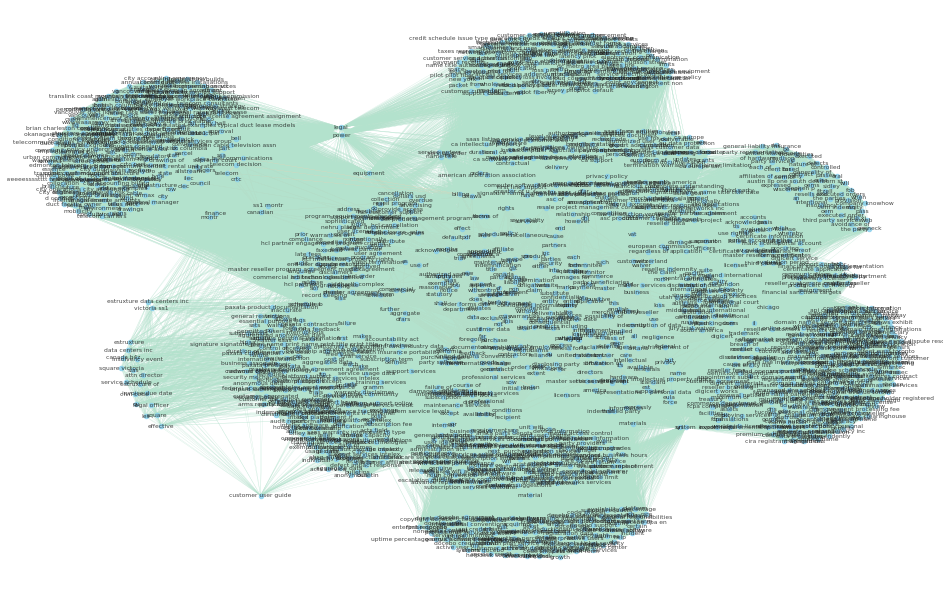

In [0]:
graph_to_plot=H
edges, weights = zip(*nx.get_edge_attributes(graph_to_plot, "weight").items())
pos = nx.spring_layout(graph_to_plot, k=0.3, iterations=40)
nx.draw(
    graph_to_plot, pos, node_color="skyblue", node_size=20, edgelist=edges,
    edge_color=weights, width=0.25, edge_cmap=plt.cm.Pastel2,
    with_labels=True, font_size=6, alpha=0.8)

plt.show()

#### Step 6: **Applying Gensim TFIDF Technique**

In [0]:
class GensimTfidfVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, dirpath=".", tofull=False):
        """
        Pass in a directory that holds the lexicon in corpus.dict and the
        TFIDF model in tfidf.model (for now).
        Set tofull = True if the next thing is a Scikit-Learn estimator
        otherwise keep False if the next thing is a Gensim model.
        """
        self._lexicon_path = os.path.join(dirpath, "corpus.dict")
        self._tfidf_path = os.path.join(dirpath, "tfidf.model")

        self.lexicon = None
        self.tfidf = None
        self.tofull = tofull
        self.load()

    def load(self):

        if os.path.exists(self._lexicon_path):
            self.lexicon = Dictionary.load(self._lexicon_path)

        if os.path.exists(self._tfidf_path):
            self.tfidf = TfidfModel().load(self._tfidf_path)

    def save(self):
        self.lexicon.save(self._lexicon_path)
        self.tfidf.save(self._tfidf_path)

    def fit(self, documents, labels=None):
        self.lexicon = Dictionary(documents)
        self.tfidf = TfidfModel([self.lexicon.doc2bow(doc) for doc in documents], id2word=self.lexicon)
        self.save()
        return self

    def transform(self, documents):
      for document in documents:
        vec = self.tfidf[self.lexicon.doc2bow(document)]
        yield sparse2full(vec, len(self.tfidf.id2word))

In [0]:
warnings.filterwarnings("ignore")
vectorizer = GensimTfidfVectorizer('/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Processed Pickle/')
vectorizer.fit(key_phrases)

vectorized_docs = list(vectorizer.transform(key_phrases))

#Save the vectors
with open(r'/gdrive/My Drive/Ashish_Mona_TelusBusinessCase/Corpus_Agreements/Processed Pickle/Vectorized_Pickle.pkl', 'wb') as f:
      pickle.dump(vectorized_docs, f)

for x in range(21): 
    print (vectorized_docs[x])

[0.01609686 0.00447979 0.00081502 ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[0.         0.         0.00162103 ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[0.         0.00900911 0.00163905 ... 0.         0.         0.        ]
[0.         0.         0.00492812 ... 0.         0.         0.        ]
[0.         0.00166465 0.00242282 ... 0.         0.         0.        ]
[0.         0.         0.00104091 ... 0.         0.         0.        ]
[0.         0.         0.00129622 ... 0.         0.         0.        ]
[0.         0.00489209 0.00801026 ... 0.         0.         0.        ]
[0.         0.         0.00111376 ... 0.         0.         0.        ]
[0.         0.         0.00823275 ... 0.         0.         0.        ]
[0.         0.         0.00400487 ... 0.         0.         0.        ]
[0.         0.00625153 0.00341206 ... 0.         0.         0.        ]
[0.         0.00470412 0.00599081 ... 0.         0.         0.        ]
[0.        0.   

### **Predict the risk of contract using K-Means Clustering Algorithm**

In [0]:
class KMeansClusters(BaseEstimator, TransformerMixin):
    def __init__(self, k=3, random_state=42):
        """
        k is the number of clusters model is the implementation of Kmeans
        """
        self.k = k
        self.seed = random_state
        self.distance = nltk.cluster.util.cosine_distance
        self.model = KMeansClusterer(self.k, self.distance, self.seed, avoid_empty_clusters=True)

    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        """
        Fits the K-Means model to one-hot vectorized documents.
        """
        return self.model.cluster(documents, assign_clusters=True)

In [0]:
model = Pipeline([
        ('clusters', KMeansClusters(k=3,random_state=42)) #Risk is categorized as High, Medium and low contracts
        ])

clusters = model.fit_transform(vectorized_docs)

In [0]:
filename = ['MRA-1','MRA-2','MSA-2','MSA-4','MSA-3','msa-6','msa-7','mra-3','mra-4','MSA-1',
            'MSA-5','msaas-1','msaas-2','msaas-5','telecom-1','msaas-4','msaas-3','telecom-4',
            'telecom-3','telecom-6','telecom-2']

for n, i in enumerate(clusters):
  if i == 0:
    clusters[n] = 'Type 1 Contract'
  elif i == 1:
    clusters[n] = 'Type 2 Contract'
  elif i == 2:
    clusters[n] = 'Type 3 Contract'

for idx, cluster in enumerate(clusters):
    print("Agreement '{}' was assigned to cluster : {}.".format(filename[idx],cluster))

Agreement 'MRA-1' was assigned to cluster : Type 3 Contract.
Agreement 'MRA-2' was assigned to cluster : Type 3 Contract.
Agreement 'MSA-2' was assigned to cluster : Type 2 Contract.
Agreement 'MSA-4' was assigned to cluster : Type 1 Contract.
Agreement 'MSA-3' was assigned to cluster : Type 2 Contract.
Agreement 'msa-6' was assigned to cluster : Type 2 Contract.
Agreement 'msa-7' was assigned to cluster : Type 2 Contract.
Agreement 'mra-3' was assigned to cluster : Type 3 Contract.
Agreement 'mra-4' was assigned to cluster : Type 3 Contract.
Agreement 'MSA-1' was assigned to cluster : Type 2 Contract.
Agreement 'MSA-5' was assigned to cluster : Type 2 Contract.
Agreement 'msaas-1' was assigned to cluster : Type 2 Contract.
Agreement 'msaas-2' was assigned to cluster : Type 2 Contract.
Agreement 'msaas-5' was assigned to cluster : Type 3 Contract.
Agreement 'telecom-1' was assigned to cluster : Type 2 Contract.
Agreement 'msaas-4' was assigned to cluster : Type 2 Contract.
Agreement 'm

**Now we define our clusters based on the risk of every contract**

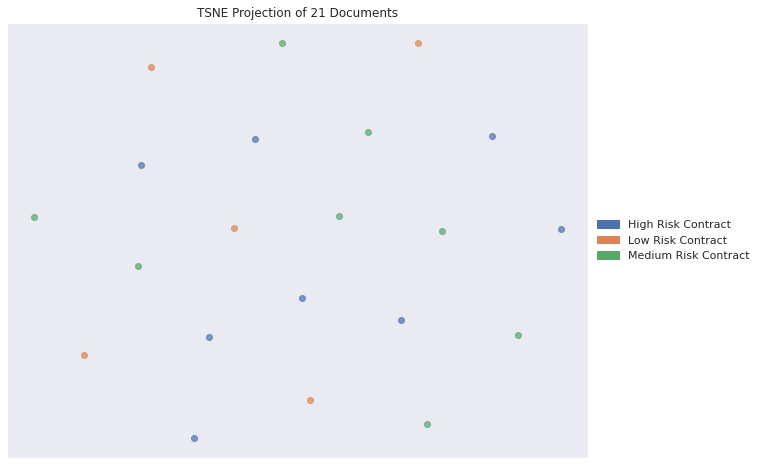

In [0]:
warnings.filterwarnings("ignore")
from yellowbrick.text import TSNEVisualizer
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

# We decide now, how to categorize the cluster.
for n, i in enumerate(clusters):
  if i == 'Type 1 Contract':
    clusters[n] = 'Low Risk Contract'
  elif i == 'Type 2 Contract':
    clusters[n] = 'High Risk Contract'
  elif i == 'Type 3 Contract':
    clusters[n] = 'Medium Risk Contract'

# Create a visualizer to simply see the vectors plotted in 2D
tsne = TSNEVisualizer()
tsne.fit(vectorized_docs,["{}".format(c) for c in clusters],)
tsne.poof()

**Out of 21 contracts, we tested. We found 6 contracts with Medium risk and 10 contracts with High Risk. We also saw the contracts having Service Level Agreement and/or Warranty terms have been clustered as High Risk Contract.** 

### **References**

1.   Text Summarization <br/>
     https://towardsdatascience.com/understand-text-summarization-and-create-your-own-summarizer-in-python-b26a9f09fc70
2.   Code References <br/> https://github.com/foxbook/atap/tree/master/snippets

3.   Named Entity Extraction <br/>
     https://www.ayobamiadewole.com/Blog/named-entity-extraction-from-text-in-python

